In [3]:
import sys
sys.path.append('/home/knikaido/work/Indoor-Location-Navigation/Git/indoor-location-competition-20')


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from dataclasses import dataclass

import plotly.offline as pyo
import matplotlib.pyplot as plt # visualization
plt.rcParams.update({'font.size': 8})
import seaborn as sns # visualization

import warnings # Supress warnings 
warnings.filterwarnings('ignore')
from pathlib import Path
import seaborn as sns
from ptitprince import RainCloud


from tqdm import tqdm
from IPython.display import Image

import json
import plotly.graph_objs as go
from PIL import Image

from main import extract_wifi_rssi, extract_wifi_count
from datetime import datetime
from main import calibrate_magnetic_wifi_ibeacon_to_position
from main import extract_magnetic_strength
from visualize_f import visualize_trajectory, visualize_heatmap

from sklearn import preprocessing


/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning:


examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.



In [5]:
DATA_DIR = Path("/home/knikaido/work/Indoor-Location-Navigation/data/")
TXT_DIR = DATA_DIR / 'indoor-location-navigation'
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'
OUTPUT_DIR = DATA_DIR / 'indoor-navigation-and-location-wifi-features-all-site'

In [6]:
ssubm = pd.read_csv(TXT_DIR / 'sample_submission.csv')

# only 24 of the total buildings are used in the test set, 
# this allows us to greatly reduce the intial size of the dataset

ssubm_df = ssubm["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))
used_buildings = sorted(ssubm_df[0].value_counts().index.tolist())

In [7]:
used_buildings

['5a0546857ecc773753327266',
 '5c3c44b80379370013e0fd2b',
 '5d27075f03f801723c2e360f',
 '5d27096c03f801723c31e5e0',
 '5d27097f03f801723c320d97',
 '5d27099f03f801723c32511d',
 '5d2709a003f801723c3251bf',
 '5d2709b303f801723c327472',
 '5d2709bb03f801723c32852c',
 '5d2709c303f801723c3299ee',
 '5d2709d403f801723c32bd39',
 '5d2709e003f801723c32d896',
 '5da138274db8ce0c98bbd3d2',
 '5da1382d4db8ce0c98bbe92e',
 '5da138314db8ce0c98bbf3a0',
 '5da138364db8ce0c98bc00f1',
 '5da1383b4db8ce0c98bc11ab',
 '5da138754db8ce0c98bca82f',
 '5da138764db8ce0c98bcaa46',
 '5da1389e4db8ce0c98bd0547',
 '5da138b74db8ce0c98bd4774',
 '5da958dd46f8266d0737457b',
 '5dbc1d84c1eb61796cf7c010',
 '5dc8cea7659e181adb076a3f']

In [8]:
sample_test = sorted(glob.glob(str(TXT_DIR / f'test/*.txt')))
sample_test

['/home/knikaido/work/Indoor-Location-Navigation/data/indoor-location-navigation/test/00ff0c9a71cc37a2ebdd0f05.txt',
 '/home/knikaido/work/Indoor-Location-Navigation/data/indoor-location-navigation/test/01c41f1aeba5c48c2c4dd568.txt',
 '/home/knikaido/work/Indoor-Location-Navigation/data/indoor-location-navigation/test/030b3d94de8acae7c936563d.txt',
 '/home/knikaido/work/Indoor-Location-Navigation/data/indoor-location-navigation/test/0389421238a7e2839701df0f.txt',
 '/home/knikaido/work/Indoor-Location-Navigation/data/indoor-location-navigation/test/04029880763600640a0cf42c.txt',
 '/home/knikaido/work/Indoor-Location-Navigation/data/indoor-location-navigation/test/0412d582bb8a2c89400a1ffb.txt',
 '/home/knikaido/work/Indoor-Location-Navigation/data/indoor-location-navigation/test/046cfa46be49fc10834815c6.txt',
 '/home/knikaido/work/Indoor-Location-Navigation/data/indoor-location-navigation/test/049bb468e7e166e9d6370002.txt',
 '/home/knikaido/work/Indoor-Location-Navigation/data/indoor-loc

In [9]:
sample_files = sorted(glob.glob(str(TXT_DIR / f'train/{used_buildings[15]}/*/*.txt')))
sample_files

['/home/knikaido/work/Indoor-Location-Navigation/data/indoor-location-navigation/train/5da138364db8ce0c98bc00f1/F1/5daeafcdaa1d300006faaeba.txt',
 '/home/knikaido/work/Indoor-Location-Navigation/data/indoor-location-navigation/train/5da138364db8ce0c98bc00f1/F1/5daeafcfaa1d300006faaebc.txt',
 '/home/knikaido/work/Indoor-Location-Navigation/data/indoor-location-navigation/train/5da138364db8ce0c98bc00f1/F1/5daeafd4e415cd00066292ab.txt',
 '/home/knikaido/work/Indoor-Location-Navigation/data/indoor-location-navigation/train/5da138364db8ce0c98bc00f1/F1/5daeafdbe415cd00066292ad.txt',
 '/home/knikaido/work/Indoor-Location-Navigation/data/indoor-location-navigation/train/5da138364db8ce0c98bc00f1/F1/5daeafdeaa1d300006faaec0.txt',
 '/home/knikaido/work/Indoor-Location-Navigation/data/indoor-location-navigation/train/5da138364db8ce0c98bc00f1/F1/5daeafdfaa1d300006faaec2.txt',
 '/home/knikaido/work/Indoor-Location-Navigation/data/indoor-location-navigation/train/5da138364db8ce0c98bc00f1/F1/5daeafdfe

In [24]:
sample_path = sample_files[0]

In [25]:
# copy from https://github.com/location-competition/indoor-location-competition-20/blob/master/io_f.py

@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])
            continue
       
        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
        
        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
        
        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
        
        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue
        
    
    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)
    
    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

sample_file = read_data_file(sample_path)

print('acce shape:', sample_file.acce.shape)
print('acce_uncali shape:', sample_file.acce_uncali.shape)
print('gyro shape:', sample_file.gyro.shape)
print('gyro_uncali shape:', sample_file.gyro_uncali.shape)
print('magn shape:', sample_file.magn.shape)
print('magn_uncali shape:',sample_file.magn_uncali.shape)
print('ahrs shape:', sample_file.ahrs.shape)
print('wifi shape:', sample_file.wifi.shape)
print('ibeacon shape:', sample_file.ibeacon.shape)
print('waypoint shape:', sample_file.waypoint.shape)

acce shape: (6891, 4)
acce_uncali shape: (6891, 4)
gyro shape: (6891, 4)
gyro_uncali shape: (6891, 4)
magn shape: (6891, 4)
magn_uncali shape: (6891, 4)
ahrs shape: (6891, 4)
wifi shape: (5241, 5)
ibeacon shape: (28, 3)
waypoint shape: (13, 3)


# Unix Timestamp
The first column is the **Unix Time in milliseconds**. If you are not familiar with Unix time, then I recommend reading up on it on [wikipedia](https://en.wikipedia.org/wiki/Unix_time). But in short, the unix time is the time elapsed since 00:00:00 UTC on 1 January 1970. 

At this point, I am not yet sure if we really need to convert Unix timestamps to human understandable timestamps but here is the conversion - just in case. Since we are working with milliseconds, we need to divide the timestamps by 1000. The above sample starts at 1573713056850 and ends at 1573713091483, which corresponds to a short 34.633 s long trace done on November 14th 2019.

In [26]:
from datetime import datetime
start_time = 1573713056850
end_time = 1573713091483

print(datetime.fromtimestamp(start_time/1000.0))
print(datetime.fromtimestamp(end_time/1000.0))
print(datetime.fromtimestamp(end_time/1000.0)-datetime.fromtimestamp(start_time/1000.0))

2019-11-14 15:30:56.850000
2019-11-14 15:31:31.483000
0:00:34.633000




# Waypoint
Let's plot the trace of the waypoint on the map first to get a feeling for this example.

The following code is also copied and edited from [@ihelon's notebook](https://www.kaggle.com/ihelon/indoor-location-exploratory-data-analysis) and is originally from the [competition's Github page](https://github.com/location-competition/indoor-location-competition-20/blob/master/visualize_f.py).

In [27]:
waypoint_df = pd.DataFrame(sample_file.waypoint)
waypoint_df.columns = ['timestamp', 'waypoint_x','waypoint_y']
waypoint_df['timestamp_ms'] = waypoint_df['timestamp'].apply(lambda x: datetime.fromtimestamp(int(x)/1000.0))
display(waypoint_df.style.set_caption('Waypoint'))

,timestamp,waypoint_x,waypoint_y,timestamp_ms
0,1571726191223.000000,27.788078,101.067470,2019-10-22 15:36:31.223000
1,1571726199002.000000,32.260090,106.229010,2019-10-22 15:36:39.002000
2,1571726214432.000000,35.490707,103.750880,2019-10-22 15:36:54.432000
3,1571726220863.000000,33.968670,101.991264,2019-10-22 15:37:00.863000
4,1571726228460.000000,31.449750,98.418550,2019-10-22 15:37:08.460000
5,1571726235520.000000,34.615690,95.737530,2019-10-22 15:37:15.520000
6,1571726245354.000000,38.495846,97.792465,2019-10-22 15:37:25.354000
7,1571726258553.000000,33.968670,101.991264,2019-10-22 15:37:38.553000
8,1571726273293.000000,27.788078,101.067470,2019-10-22 15:37:53.293000
9,1571726284488.000000,31.449750,98.418550,2019-10-22 15:38:04.488000


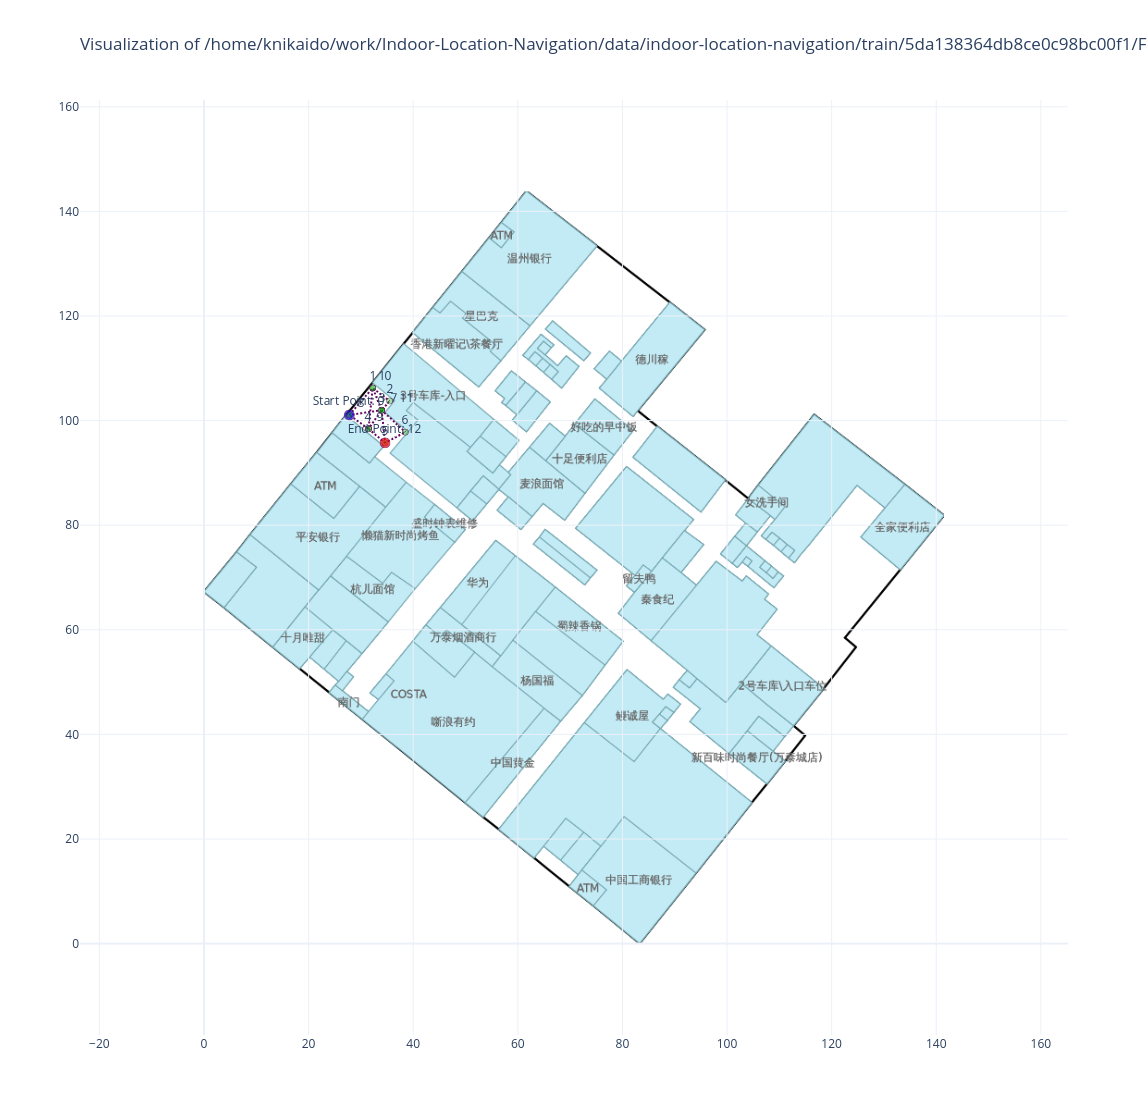

In [28]:
def visualize_train_trajectory(path):
    """
    Edited from 
    https://www.kaggle.com/ihelon/indoor-location-exploratory-data-analysis
    """
    _id, floor = path.split("/")[-3:-1]
    
    train_floor_data = read_data_file(path)
    with open(TXT_DIR / f"metadata/{_id}/{floor}/floor_info.json") as f:
        train_floor_info = json.load(f)
        
    visualize_trajectory(
            train_floor_data.waypoint[:, 1:3], 
            TXT_DIR / f"metadata/{_id}/{floor}/floor_image.png",
            train_floor_info["map_info"]["width"], 
            train_floor_info["map_info"]["height"],
            f"Visualization of {path}",
            show=True,
        )

    return train_floor_data
#visualize_train_trajectory("5a0546857ecc773753327266/F2/5d8f094bd5bae80006eb8db0.txt")
#visualize_train_trajectory("5a0546857ecc773753327266/F2/5d8f094bb6e29d0006fb8c03.txt")
#visualize_train_trajectory("5a0546857ecc773753327266/F2/5dccf511c04f060006e6e3c6.txt")
train_floor_data = visualize_train_trajectory(sample_path)

In [29]:
train_floor_data = read_data_file(sample_path)

## Wifiのtimestampとlstimestampとwaypoint

In [30]:
wifi_df = pd.DataFrame(train_floor_data.wifi)
wifi_df.columns = ['timestamp', 'ssid', 'bssid', 'rssi', 'last_seen_timestamp']
wifi_df

,timestamp,ssid,bssid,rssi,last_seen_timestamp
0,1571726193111,4291d00492758079d3444ae382de1200de6b231b,3c66502f1b485937a8ba4953db320b3e1a888090,-56,1571726192843
1,1571726193111,4291d00492758079d3444ae382de1200de6b231b,f166bfd6af62dce2355341fab368c10bf26c942e,-63,1571726192093
2,1571726193111,4291d00492758079d3444ae382de1200de6b231b,f65d6fb74e41feac7a437bc804a9e7d468e75b1d,-65,1571726191353
3,1571726193111,4291d00492758079d3444ae382de1200de6b231b,f06561193e445e06bd9394c139175f543f584d07,-69,1571726191473
4,1571726193111,4291d00492758079d3444ae382de1200de6b231b,36f8ea04377da36d241586529a8192c5d91839fe,-70,1571726192156
...,...,...,...,...,...
5236,1571726326907,05da5d26a790730a50fbbf2df49c66fe8f8c02a3,ac6304ef55471cfd64c8fd9e0ab5c388aef43949,-91,1571726324377
5237,1571726326907,db19a1faff792fb000386abce1d0bb4ee50d8e57,3acae969f5be879079d00f038863709908b1cf0c,-91,1571726297811
5238,1571726326907,e7ca297ffcb8b0a9a5358257d4c19e6a2e855abe,7c4d9bf172efc04a3b0ffbfc8740384b70ae88a7,-91,1571726302711
5239,1571726326907,551220deeb362077f5df356bdebaf94f34f93f0c,d075ab608f50953d37a345f2fe9cd981ad3a3aa4,-91,1571726309326


In [31]:
wifi_df['timestamp_ms'] = wifi_df['timestamp'].apply(lambda x: datetime.fromtimestamp(int(x)/1000.0))
wifi_df['last_seen_timestamp_ms'] = wifi_df['last_seen_timestamp'].apply(lambda x: datetime.fromtimestamp(int(x)/1000.0))
wifi_df['time_diff'] = wifi_df['timestamp_ms'] - wifi_df['last_seen_timestamp_ms'] 
wifi_df['path'] = sample_files[0]

In [32]:
wifi_df.sort_values('time_diff', ascending=False)

,timestamp,ssid,bssid,rssi,last_seen_timestamp,timestamp_ms,last_seen_timestamp_ms,time_diff,path
1073,1571726225391,e7ca297ffcb8b0a9a5358257d4c19e6a2e855abe,c058b9dbadbb9e83af1ed4f3bed9cdcc6473e483,-83,1571726195357,2019-10-22 15:37:05.391,2019-10-22 15:36:35.357,00:00:30.034000,/home/knikaido/work/Indoor-Location-Navigation...
4763,1571726316845,3f034fc254839b5f3c3495bc7db422e193ab6e21,ebb7b81abdd21113656d4f46c185e9fe1663c9bc,-92,1571726286819,2019-10-22 15:38:36.845,2019-10-22 15:38:06.819,00:00:30.026000,/home/knikaido/work/Indoor-Location-Navigation...
1062,1571726225391,da39a3ee5e6b4b0d3255bfef95601890afd80709,9fdf8d10078ae4747b92ccf6a64a4c2d33522da6,-80,1571726195393,2019-10-22 15:37:05.391,2019-10-22 15:36:35.393,00:00:29.998000,/home/knikaido/work/Indoor-Location-Navigation...
1020,1571726223487,9eab102e8f9431bb23016851d11e658e0b20b730,050ab2d17b4433cce44b46156d9a7d0cc81a8a3c,-86,1571726193495,2019-10-22 15:37:03.487,2019-10-22 15:36:33.495,00:00:29.992000,/home/knikaido/work/Indoor-Location-Navigation...
2029,1571726250039,02dcb82ab2fb93f2c8187fa51ce36eafe8a6203d,0c5bca5588d086721514cb124a5124fe2c800cea,-81,1571726220052,2019-10-22 15:37:30.039,2019-10-22 15:37:00.052,00:00:29.987000,/home/knikaido/work/Indoor-Location-Navigation...
...,...,...,...,...,...,...,...,...,...
383,1571726206365,4291d00492758079d3444ae382de1200de6b231b,3c66502f1b485937a8ba4953db320b3e1a888090,-65,1571726206083,2019-10-22 15:36:46.365,2019-10-22 15:36:46.083,00:00:00.282000,/home/knikaido/work/Indoor-Location-Navigation...
835,1571726219671,4291d00492758079d3444ae382de1200de6b231b,3c66502f1b485937a8ba4953db320b3e1a888090,-65,1571726219393,2019-10-22 15:36:59.671,2019-10-22 15:36:59.393,00:00:00.278000,/home/knikaido/work/Indoor-Location-Navigation...
318,1571726204484,4291d00492758079d3444ae382de1200de6b231b,3c66502f1b485937a8ba4953db320b3e1a888090,-48,1571726204208,2019-10-22 15:36:44.484,2019-10-22 15:36:44.208,00:00:00.276000,/home/knikaido/work/Indoor-Location-Navigation...
4751,1571726316845,4291d00492758079d3444ae382de1200de6b231b,aeff1e6a8bbad67c8b7619cb315f623197dab40f,-88,1571726316573,2019-10-22 15:38:36.845,2019-10-22 15:38:36.573,00:00:00.272000,/home/knikaido/work/Indoor-Location-Navigation...


(737354.6503832291, 737354.651931794)

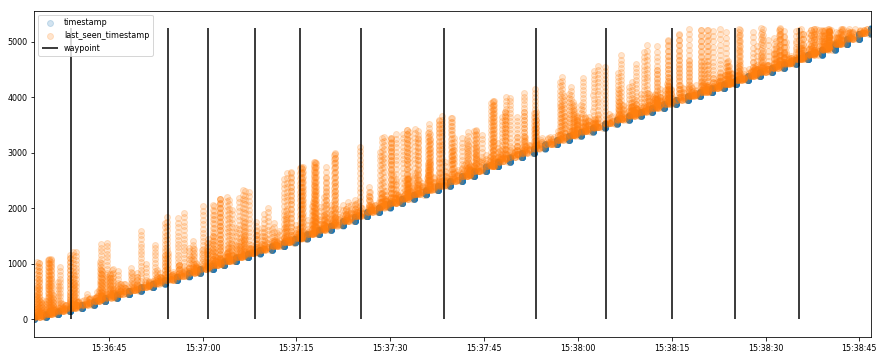

In [33]:
plt.figure(figsize=(15, 6))
plt.scatter(wifi_df['timestamp_ms'], wifi_df.index, alpha=0.2, label='timestamp')
plt.scatter(wifi_df['last_seen_timestamp_ms'], wifi_df.index, alpha=0.2, label='last_seen_timestamp')
plt.vlines(waypoint_df['timestamp_ms'], ymin=0, ymax=len(wifi_df), label='waypoint')
plt.legend()
plt.xlim([wifi_df['timestamp_ms'].iloc[0], wifi_df['timestamp_ms'].iloc[-1]])

In [34]:
le = preprocessing.LabelEncoder()
le.fit(wifi_df['timestamp_ms'])
wifi_df['timestamp_group'] = le.transform(wifi_df['timestamp_ms'])

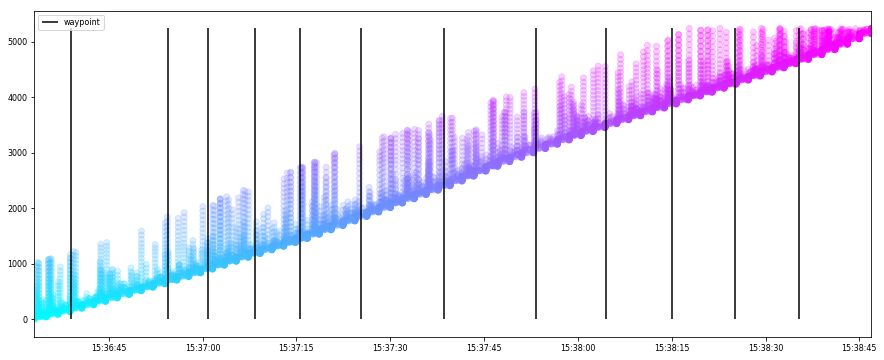

In [35]:
plt.figure(figsize=(15, 6))
plt.scatter(wifi_df['timestamp_ms'], wifi_df.index, cmap=plt.cm.cool, alpha=0.2, c=wifi_df['timestamp_group'])
plt.scatter(wifi_df['last_seen_timestamp_ms'], wifi_df.index, cmap=plt.cm.cool, alpha=0.2, c=wifi_df['timestamp_group'])
plt.xlim([wifi_df['timestamp_ms'].iloc[0], wifi_df['timestamp_ms'].iloc[-1]])
plt.vlines(waypoint_df['timestamp_ms'], ymin=0, ymax=len(wifi_df), label='waypoint')
plt.legend()

lstimestampおもったよりまえにもあるじゃんの図

In [36]:
wifi_df_sort = wifi_df.sort_values('last_seen_timestamp').reset_index(drop=True)

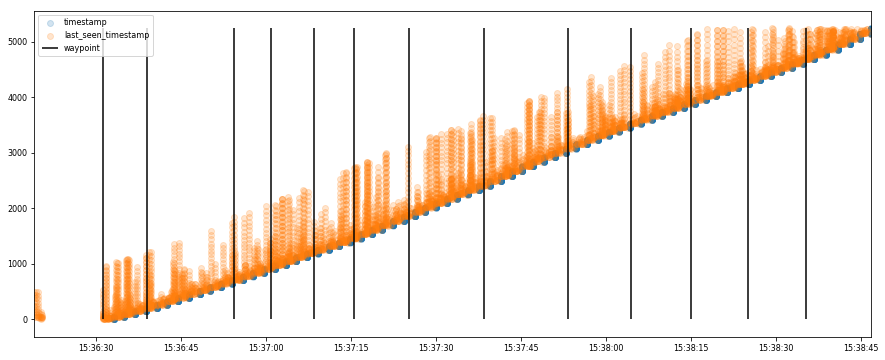

In [37]:
plt.figure(figsize=(15, 6))
plt.scatter(wifi_df['timestamp_ms'], wifi_df.index, alpha=0.2, label='timestamp')
plt.scatter(wifi_df['last_seen_timestamp_ms'], wifi_df.index, alpha=0.2, label='last_seen_timestamp')
plt.vlines(waypoint_df['timestamp_ms'], ymin=0, ymax=len(wifi_df), label='waypoint')
plt.xlim([wifi_df_sort['last_seen_timestamp_ms'].iloc[0], wifi_df['timestamp_ms'].iloc[-1]])
plt.legend()

In [291]:
sample_files = sorted(glob.glob(str(TXT_DIR / f'train/{used_buildings[23]}/*/*.txt')))

In [302]:
# sample_path = sample_files[-10]
sample_path = sample_test[-10]
train_floor_data = read_data_file(sample_path)

In [379]:
waypoint_df = pd.DataFrame(train_floor_data.waypoint)
waypoint_df.columns = ['timestamp', 'waypoint_x','waypoint_y']
waypoint_df['timestamp_ms'] = waypoint_df['timestamp'].apply(lambda x: datetime.fromtimestamp(int(x)/1000.0))

In [380]:

wifi_df = pd.DataFrame(train_floor_data.wifi)
wifi_df.columns = ['timestamp', 'ssid', 'bssid', 'rssi', 'last_seen_timestamp']
wifi_df['timestamp_ms'] = wifi_df['timestamp'].apply(lambda x: datetime.fromtimestamp(int(x)/1000.0))
wifi_df['last_seen_timestamp_ms'] = wifi_df['last_seen_timestamp'].apply(lambda x: datetime.fromtimestamp(int(x)/1000.0))
wifi_df['time_diff'] = wifi_df['timestamp_ms'] - wifi_df['last_seen_timestamp_ms'] 

In [381]:
wifi_df_sort = wifi_df.sort_values('last_seen_timestamp').reset_index(drop=True)

In [382]:
import datetime as dt
delta= dt.timedelta(seconds=10)
delta

datetime.timedelta(0, 10)

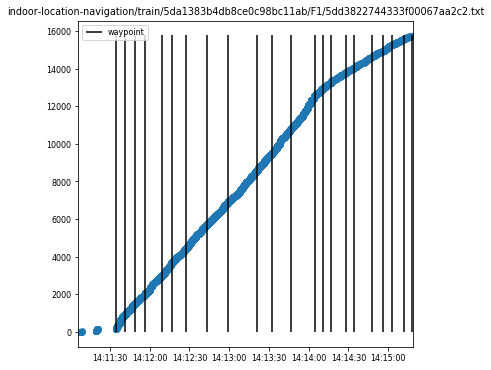

In [383]:
plt.figure(figsize=(6, 6))
plt.scatter(wifi_df_sort['last_seen_timestamp_ms'], wifi_df.index, cmap=plt.cm.cool, alpha=0.2)
plt.xlim([wifi_df_sort['last_seen_timestamp_ms'].iloc[0], wifi_df_sort['last_seen_timestamp_ms'].iloc[-1]])
plt.vlines(waypoint_df['timestamp_ms'], ymin=0, ymax=len(wifi_df), label='waypoint')
plt.title(sample_path.split('/', 6)[-1])
plt.legend()

In [ ]:
sample_files = sorted(glob.glob(str(TXT_DIR / f'train/{used_buildings[0]}/*/*.txt')))

sample_path = sample_files[4]
train_floor_data = read_data_file(sample_path)
waypoint_df = pd.DataFrame(train_floor_data.waypoint)
waypoint_df.columns = ['timestamp', 'waypoint_x','waypoint_y']
waypoint_df['timestamp_ms'] = waypoint_df['timestamp'].apply(lambda x: datetime.fromtimestamp(int(x)/1000.0))


wifi_df = pd.DataFrame(train_floor_data.wifi)
wifi_df.columns = ['timestamp', 'ssid', 'bssid', 'rssi', 'last_seen_timestamp']
wifi_df['timestamp_ms'] = wifi_df['timestamp'].apply(lambda x: datetime.fromtimestamp(int(x)/1000.0))
wifi_df['last_seen_timestamp_ms'] = wifi_df['last_seen_timestamp'].apply(lambda x: datetime.fromtimestamp(int(x)/1000.0))
wifi_df['time_diff'] = wifi_df['timestamp_ms'] - wifi_df['last_seen_timestamp_ms'] 
wifi_df_sort = wifi_df.sort_values('last_seen_timestamp').reset_index(drop=True)

plt.figure(figsize=(6, 6))
plt.scatter(wifi_df_sort['last_seen_timestamp_ms'], wifi_df.index, cmap=plt.cm.cool, alpha=0.2)
plt.xlim([wifi_df_sort['last_seen_timestamp_ms'].iloc[0], wifi_df_sort['last_seen_timestamp_ms'].iloc[-1]])
plt.vlines(waypoint_df['timestamp_ms'], ymin=0, ymax=len(wifi_df), label='waypoint')
plt.title(sample_path.split('/', 6)[-1])
plt.legend()



In [249]:
wifi_df_sort['last_seen_timestamp_group'] = 0

ind = 0
group = 0
while ind < len(wifi_df_sort['last_seen_timestamp_ms']):
    sita = wifi_df_sort['last_seen_timestamp_ms'][ind]
    ue = delta + wifi_df_sort['last_seen_timestamp_ms'][ind]
    tgt_ind = wifi_df_sort[(wifi_df_sort['last_seen_timestamp_ms'] >= sita) & (wifi_df_sort['last_seen_timestamp_ms'] <= ue)].index
    wifi_df_sort['last_seen_timestamp_group'][list(tgt_ind)] = group
    group += 1
    ind += len(tgt_ind)

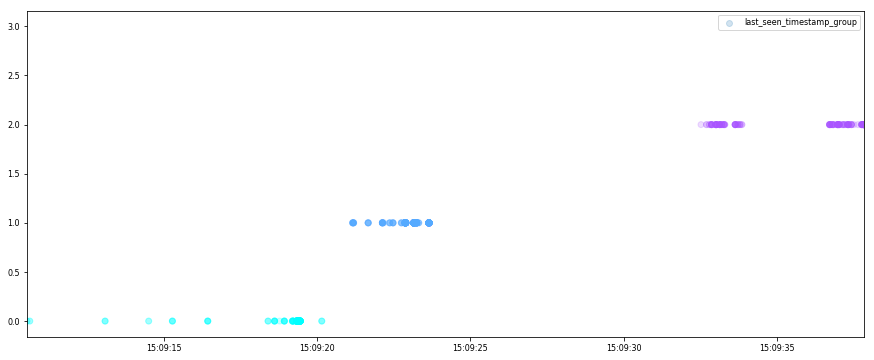

In [250]:
plt.figure(figsize=(15, 6))
plt.scatter(wifi_df_sort['last_seen_timestamp_ms'], wifi_df_sort['last_seen_timestamp_group'], cmap=plt.cm.cool, alpha=0.2, c=wifi_df_sort['last_seen_timestamp_group'])
plt.xlim([wifi_df_sort['last_seen_timestamp_ms'].iloc[0], wifi_df['last_seen_timestamp_ms'].iloc[-1]])

plt.legend()